In [1]:
#to prevent gpu to collapse it allow using at 50% of total gpu
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [2]:
# importing usefull transfer learning libraries

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from keras.applications.vgg16 import VGG16

In [3]:
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import tensorflow as tf
import numpy as np
import cv2
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [23]:
# re-size all the images to this
image_size = [224, 224]

train_path = '/content/drive/MyDrive/brain_tumors/new_brain_data/Training'
valid_path = '/content/drive/MyDrive/brain_tumors/new_brain_data/Testing'

In [25]:
vgg= VGG16(input_shape=image_size + [3], weights='imagenet', include_top=False)

In [26]:
# don't train existing weights
for layer in vgg.layers:
    layer.trainable = False

In [27]:
folders = glob('/content/drive/MyDrive/brain_tumors/new_brain_data/*')

In [28]:
# adding input and output layers
x = Flatten()(vgg.output)


In [29]:
#initializing the inner layers by using sigmoid function
prediction = Dense(4, activation='softmax')(x)

# create a model object
model = Model(inputs=vgg.input, outputs=prediction)

In [30]:
# view the structure of the model
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [31]:
# using this to tackle with loss cost and optimizer input weights by comparing the prediction and the loss function
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  #matrix for accuracy
  metrics=['accuracy']
)

In [32]:
# Use the Image Data Generator to import the images from the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

In [33]:
#by using the image generator for importing images
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dg = ImageDataGenerator(rescale = 1./255, 
                              shear_range =0.2,
                              zoom_range = 0.2,
                              horizontal_flip = True
                              )
test_dg = ImageDataGenerator(rescale = 1./255)

In [34]:
training_set = train_datagen.flow_from_directory('/content/drive/MyDrive/Dataset/brain_tumors/new_brain_data/Training',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 5712 images belonging to 4 classes.


In [35]:
test_set = test_dg.flow_from_directory('/content/drive/MyDrive/Dataset/brain_tumors/new_brain_data/Testing',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 1321 images belonging to 4 classes.


In [36]:
test_set.class_indices

{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}

In [37]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
checkpoint=ModelCheckpoint('/content/drive/MyDrive/Dataset/brain_tumors/brain.h5',
                          mode='auto',
                          monitor='val_accuracy',
                          save_best_only=True,
                          verbose=1
                           )
earlystop=EarlyStopping(monitor='val_loss',
                       min_delta=0,
                       patience=4,
                       verbose=1,
                       restore_best_weights=True
                      )
callbacks=[checkpoint,earlystop]

In [38]:
#training my model wtih dense last layer and flatting the first layer
r = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=50,
  steps_per_epoch=len(training_set),
  callbacks=callbacks,
  validation_steps=len(test_set), 

)

<ipython-input-38-2ed641009753>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  r = model.fit_generator(


Epoch 1/50
179/179 [==============================] - ETA: 0s - loss: 0.5658 - accuracy: 0.7950
Epoch 1: val_accuracy improved from -inf to 0.83876, saving model to /content/drive/MyDrive/Dataset/brain_tumors/brain.h5
179/179 [==============================] - 100s 550ms/step - loss: 0.5658 - accuracy: 0.7950 - val_loss: 0.4820 - val_accuracy: 0.8388
Epoch 2/50
179/179 [==============================] - ETA: 0s - loss: 0.2829 - accuracy: 0.8960
Epoch 2: val_accuracy improved from 0.83876 to 0.87964, saving model to /content/drive/MyDrive/Dataset/brain_tumors/brain.h5
179/179 [==============================] - 94s 523ms/step - loss: 0.2829 - accuracy: 0.8960 - val_loss: 0.3438 - val_accuracy: 0.8796
Epoch 3/50
179/179 [==============================] - ETA: 0s - loss: 0.2226 - accuracy: 0.9193
Epoch 3: val_accuracy improved from 0.87964 to 0.90310, saving model to /content/drive/MyDrive/Dataset/brain_tumors/brain.h5
179/179 [==============================] - 92s 511ms/step - loss: 0.222

In [39]:
model.save("vgg16.h5")

In [40]:
import matplotlib.pyplot as plt

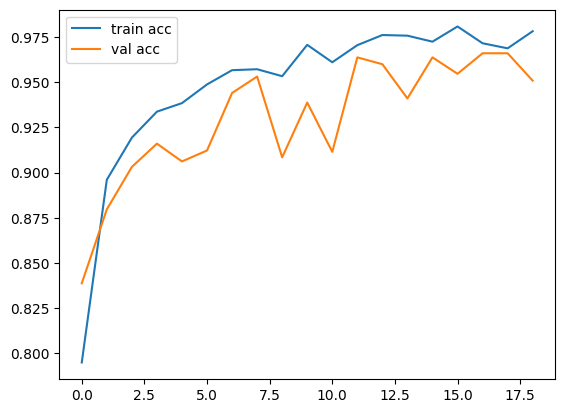

<Figure size 640x480 with 0 Axes>

In [41]:
# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

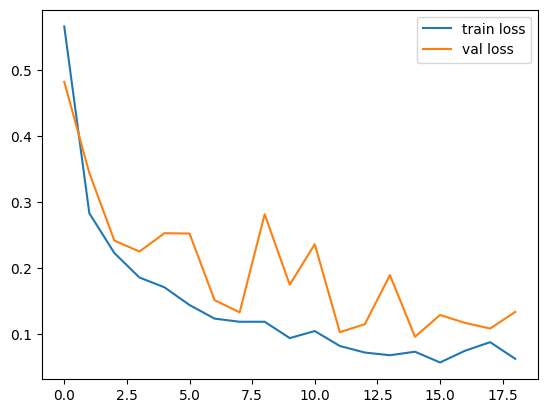

<Figure size 640x480 with 0 Axes>

In [42]:
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

In [43]:
model.save("VGG16.h5")